In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob

import scipy.stats as ss
import scipy.optimize as opt

import sys
sys.path.insert(0, '../util/')
from util_os import util_os

In [2]:
matplotlib.rc('font', family='serif')
rcParams['axes.linewidth'] = 3
rcParams['xtick.major.width'] = 3
rcParams['xtick.major.size'] = 12
rcParams['ytick.major.width'] = 3
rcParams['ytick.major.size'] = 12

rcParams['xtick.minor.width'] = 2
rcParams['xtick.minor.size'] = 8
rcParams['ytick.minor.width'] = 2
rcParams['ytick.minor.size'] = 8

rcParams['font.family'] = 'serif'

rcParams['text.usetex'] = False

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.transparent'] = False

# Set up 

In [3]:
# for keck 
fit = fits.open('keck_breathing_mode_dwarfs_v2.5.fits')
data = fit[1].data

qualitymask = data['quality']>=1

ssfr_keck = data['ssfr'][qualitymask] # log
mass_keck = data['mass'][qualitymask] #log 
vdisp_keck= data['vdisp_corr'][qualitymask]
hlr_keck  = data['R50_kpc'][qualitymask]
z_keck = data['redshift_keck'][qualitymask]

# make cuts for ssfr and sigma 
ssfr_min = -11
ssfr_max = -8

sigma_min = 0
sigma_max = 100

# cut on ssfr 
ssfrmask = ssfr_keck>=ssfr_min

z_cut = z_keck[ssfrmask]
ssfr_keck_cut = ssfr_keck[ssfrmask]
vdisp_keck_cut = vdisp_keck[ssfrmask]
hlr_keck_cut = hlr_keck[ssfrmask]
mass_keck_cut = mass_keck[ssfrmask]

ssfrmask = ssfr_keck_cut<=ssfr_max

z_cut = z_cut[ssfrmask]
ssfr_keck_cut = ssfr_keck_cut[ssfrmask]
vdisp_keck_cut = vdisp_keck_cut[ssfrmask]
hlr_keck_cut = hlr_keck_cut[ssfrmask]
mass_keck_cut = mass_keck_cut[ssfrmask]

# cut on sigma 
sigmamask = vdisp_keck_cut>sigma_min

z_cut = z_cut[sigmamask]
ssfr_keck_cut = ssfr_keck_cut[sigmamask]
vdisp_keck_cut = vdisp_keck_cut[sigmamask]
hlr_keck_cut = hlr_keck_cut[sigmamask]
mass_keck_cut = mass_keck_cut[sigmamask]

sigmamask = vdisp_keck_cut<sigma_max

z_cut = z_cut[sigmamask]
ssfr_keck_cut = ssfr_keck_cut[sigmamask]
vdisp_keck_cut = vdisp_keck_cut[sigmamask]
hlr_keck_cut = hlr_keck_cut[sigmamask]
mass_keck_cut = mass_keck_cut[sigmamask]

In [4]:
# for fire
datapath_fire = '/home/jw1624/H1-merian/fire/csvs'
galfiles_fire = glob.glob(datapath_fire+'/*.txt')
galfiles_fire.sort()

galnames_fire = ['m11b', 'm11d', 'm11e', 'm11h', 'm11i', 'm11q']

In [5]:
# for romulus
datapath_romulus = '/home/jw1624/H1-merian/csvs/breathingModes/'

galaxies_romulus = util_os.getGalaxies()[0]

# First, Overplot FIRE and Keck

In [14]:
def linlog(x, a, b):
    return 10**(a*x +b)

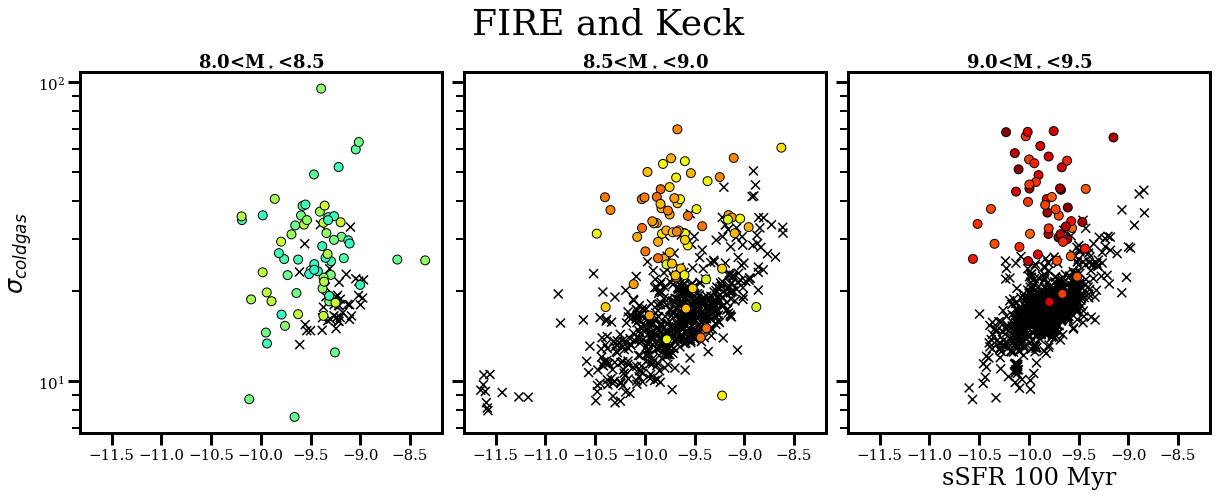

In [16]:
# SIG
fig, axs = plt.subplots(1,3, figsize=(17,7), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 2.5

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.0,8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigCG = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galfiles_fire[1:]):
        
        data = pd.read_csv(gal)
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigCG.append(y[j])
            mall.append(mm[j])
        
    ssfr = np.array(ssfr)
    sigCG = np.array(sigCG)
    mall = np.array(mall)
        
    ax.scatter(ssfr, sigCG, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    ax.set_yscale('log')
    
    # fit sim data 
    #if i==0:continue
    #popt,pcov = opt.curve_fit(f=linlog, xdata=ssfr, ydata=sigCG, p0=[1,15])
    #perr = np.sqrt(np.diag(pcov))
    
    #pts = np.array([-8,-12])
    #ax.plot(pts, linlog(pts, popt[0],popt[1]))
    
    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = vdisp_keck_cut[massmask]

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5)
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    
    #ax.set_xlim([-11.5,-8.5])
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[2].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{coldgas}$', fontsize=24)

plt.suptitle('FIRE and Keck', fontsize=36)
plt.tight_layout()

pf = '../figures/keck/comboFIRE_ssfr100_sigCG_3.png'
plt.savefig(pf)

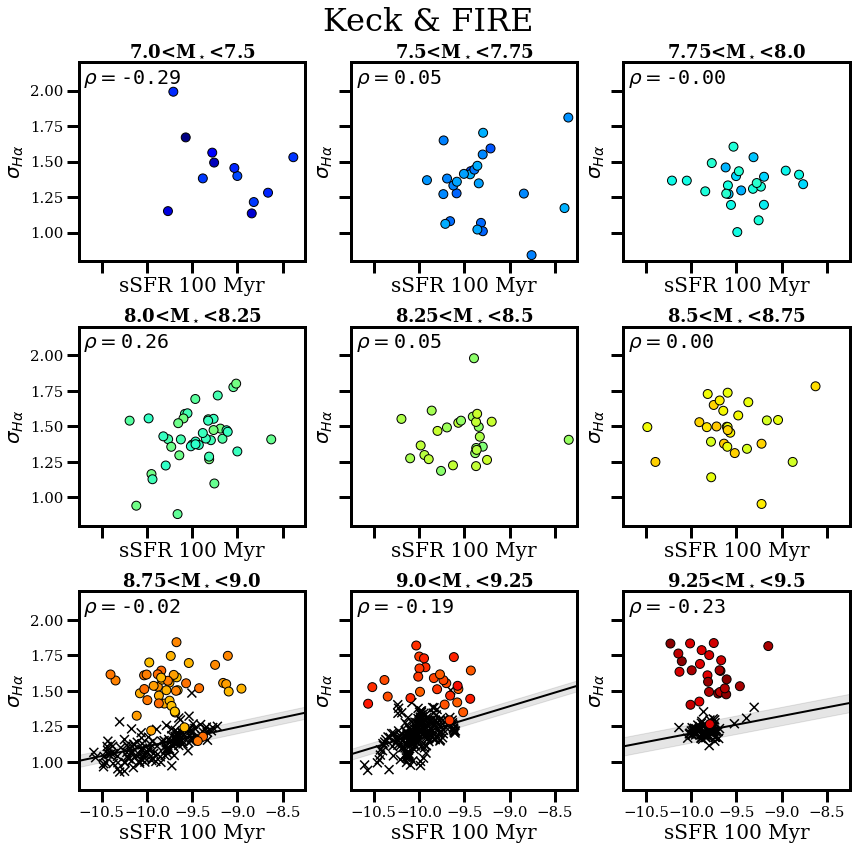

In [16]:
##
def sigmapred(x, a, b, c):
    x0,x1 = x
    return a*x0 + b*x1 + c*x0*x1
##

fig, axs = plt.subplots(3,3, figsize=(12,12), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [7.0, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5]
axes = [0 for _ in range(10)]
axes[:2] = axs[0,:]
axes[3:5] = axs[1,:]
axes[6:] = axs[2,:]
for i,ax in enumerate(axes):
    ssfr = []
    sigCG = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    ssfr = []
    sigCG = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galfiles_fire[1:]):
        
        data = pd.read_csv(gal)
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigCG.append(y[j])
            mall.append(mm[j])
        
    ssfr = np.array(ssfr)
    sigCG = np.array(sigCG)
    mall = np.array(mall)
        
    sigCG = np.log10(sigCG)
        
    ax.scatter(ssfr, sigCG, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    
    ax.set_xlim([-10.75, -8.25])
    ax.set_ylim([0.8,2.2])
    
    # for each mass bin fit predicted sigma of galaxies
    if len(mall)>0:
        popt,pcov = opt.curve_fit(f=sigmapred, xdata=np.array([ssfr,mall]), ydata=sigCG, p0=[0.1,0.4,0.01])
        perr = np.sqrt(np.diag(pcov))
    
        pts = np.array([-8,-12])
        mmean = np.mean(mall)#[-8,mmean],[-12,mmean]
        sp = sigmapred(np.array([[-8,-12],[mmean,mmean]]), popt[0], popt[1], popt[2])
        ax.plot(pts, sp, c='k', linewidth=2)
    
        # rms for error 
        rms = np.sqrt(np.mean(sigCG**2)/sum(sigCG))
        ax.fill_between([-8,-12], sp-rms/2, sp+rms/2, alpha=0.1, color='k')
    
    ## 
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]

    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = np.log10(vdisp_keck_cut[massmask])

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, zorder=3)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    p = ss.spearmanr(x, y)[0]
    numdig = 4
    if p<0: numdig = 5
    ax.text(s=r'$\rho = $'+str(p)[:numdig], x=-10.7, y=2.05, fontsize=20, fontfamily='monospace')
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    ax.set_xlabel('sSFR 100 Myr', fontsize=20)
    ax.set_ylabel(r'$\sigma_{H\alpha}$', fontsize=20)
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='7%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=16, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=16)
#plt.subplots_adjust(wspace=0)

plt.suptitle('Keck & FIRE', fontsize=32)
plt.tight_layout()

pf = '../figures/keck/9panel/comboFire_ssfr100_sigmaHa_b9.png'
#plt.savefig(pf, dpi=600)

# Romulus and Keck

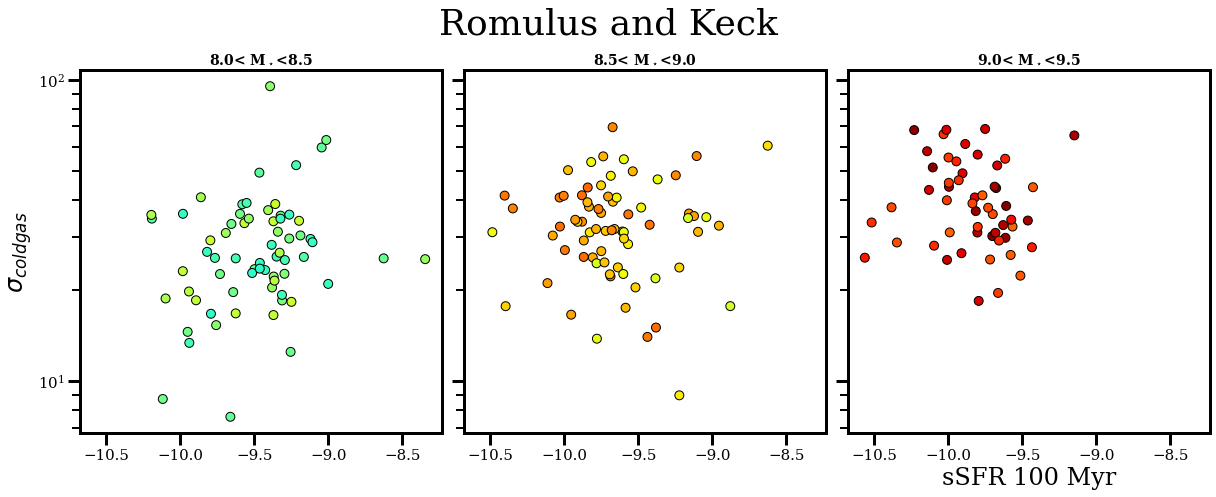

In [6]:
# SIG
fig, axs = plt.subplots(1,3, figsize=(17,7), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.0,8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigCG = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galaxies_romulus):
        if gal in [431, 615]: continue
        
        data = pd.read_csv(datapath_romulus+'r'+str(gal)+'_qtys.txt')
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_hotgas_global'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigCG.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigCG, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    ax.set_yscale('log')
    
    # fit sim data 
#    if i==0:continue
    #popt,pcov = opt.curve_fit(f=linlog, xdata=ssfr, ydata=sigCG, p0=[1,15])
    #perr = np.sqrt(np.diag(pcov))
    
    #pts = np.array([-8,-12])
    #ax.plot(pts, linlog(pts, popt[0],popt[1]))
    #ax.plot(pts, linlog(pts, popt[0]+perr[0], popt[1]+perr[1]))
    #ax.plot(pts, linlog(pts, popt[0]-perr[0], popt[1]-perr[1]))
    
    fs = 14
    ax.set_title(str(mstar_min)+'< M$_\star$<'+str(mstar_max), fontsize=fs, weight='bold')
    
    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = vdisp_keck_cut[massmask]

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5)
    
    #ax.set_xlim([-11.5,-8.5])
    #ax.set_ylim([10**0.7, 10**2.1])
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[2].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{coldgas}$', fontsize=24)

plt.suptitle('Romulus and Keck', fontsize=36)
plt.tight_layout()

pf = '../figures/keck/comboRom_ssfr100_sigCG_3.png'
#plt.savefig(pf)

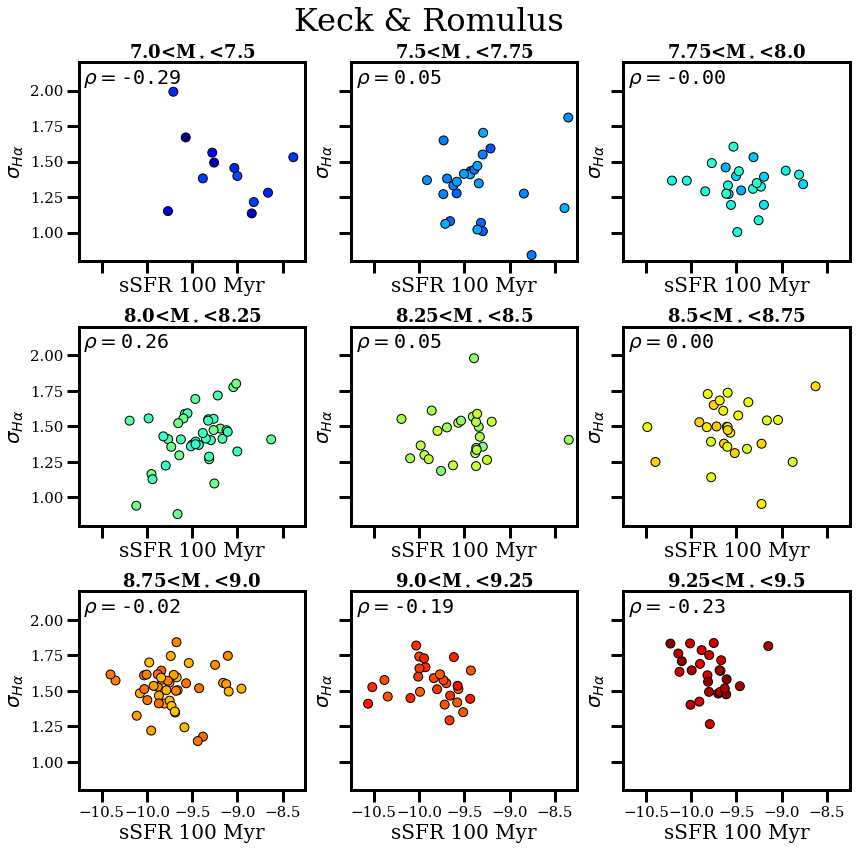

In [11]:
##
def sigmapred(x, a, b, c):
    x0,x1 = x
    return a*x0 + b*x1 + c*x0*x1
##

fig, axs = plt.subplots(3,3, figsize=(12,12), facecolor='w', sharex=True, sharey=True)

zmin = 0.0
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [7.0, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5]
axes = [0 for _ in range(10)]
axes[:2] = axs[0,:]
axes[3:5] = axs[1,:]
axes[6:] = axs[2,:]
for i,ax in enumerate(axes):
    ssfr = []
    sigCG = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galaxies_romulus):
        if gal in [431, 615]: continue
        
        data = pd.read_csv(datapath_romulus+'r'+str(gal)+'_qtys.txt')
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigCG.append(y[j])
            mall.append(mm[j])
      
    sigCG = np.log10(sigCG)
    
    ax.scatter(ssfr, sigCG, c=mall, cmap='jet', s=90, ec='tab:purple', vmin=7,vmax=9.5, marker='x')
    ax.set_xlim([-10.75, -8.25])
    ax.set_ylim([0.8,2.2])
    
    # for each mass bin fit predicted sigma of galaxies
    if len(mall)>0:
        popt,pcov = opt.curve_fit(f=sigmapred, xdata=np.array([ssfr,mall]), ydata=sigCG, p0=[0.1,0.4,0.01])
        perr = np.sqrt(np.diag(pcov))
    
        pts = np.array([-8,-12])
        mmean = np.mean(mall)#[-8,mmean],[-12,mmean]
        sp = sigmapred(np.array([[-8,-12],[mmean,mmean]]), popt[0], popt[1], popt[2])
        ax.plot(pts, sp, c='tab:purple', linewidth=2)
    
        # rms for error 
        rms = np.sqrt(np.mean(sigCG**2)/sum(sigCG))
        ax.fill_between([-8,-12], sp-rms/2, sp+rms/2, alpha=0.1, color='tab:purple')
    
    ## 
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]

    massmask = mass_keck_cut >= mstar_min
    mm = mass_keck_cut[massmask]
    x = ssfr_keck_cut[massmask]
    y = np.log10(vdisp_keck_cut[massmask])

    massmask = mm<=mstar_max
    mm = mm[massmask]
    x = x[massmask]
    y = y[massmask]

    s=ax.scatter(x, y, c=mm, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, zorder=3)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)

    p = ss.spearmanr(x, y)[0]
    numdig = 4
    if p<0: numdig = 5
    ax.text(s=r'$\rho = $'+str(p)[:numdig], x=-10.7, y=2.05, fontsize=20, fontfamily='monospace')
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    ax.set_xlabel('sSFR 100 Myr', fontsize=20)
    ax.set_ylabel(r'$\sigma_{H\alpha}$', fontsize=20)
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='7%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=16, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=16)
#plt.subplots_adjust(wspace=0)

plt.suptitle('Keck & Romulus', fontsize=32)
plt.tight_layout()

pf = '../figures/keck/9panel/comboRom_ssfr100_sigmaHa_b9.png'
#plt.savefig(pf, dpi=600)

# Romulus and Fire

<ipython-input-7-091fce827bc0>:71: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-7-091fce827bc0>:72: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]
<ipython-input-7-091fce827bc0>:71: RuntimeWarning: divide by zero encountered in log10
  massmask = np.log10(np.array(data['M_star']))>= mstar_min
<ipython-input-7-091fce827bc0>:72: RuntimeWarning: divide by zero encountered in log10
  mm = np.log10(np.array(data['M_star']))[massmask]


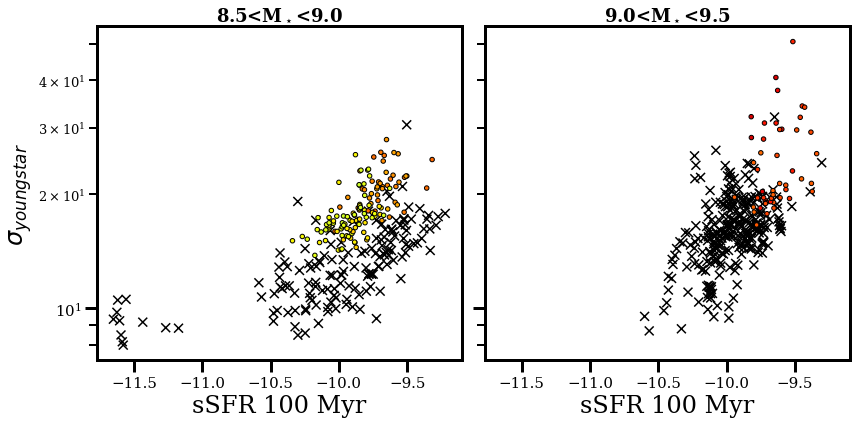

In [7]:
# SIG
fig, axs = plt.subplots(1,2, figsize=(12,6), facecolor='w', sharex=True, sharey=True)

zmin = 0.00
zmax = 0.35

#mbins = [7.0, 7.5, 8.0, 8.5, 9.0, 9.5]
mbins = [8.5,9.0,9.5]

for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galfiles_fire[1:]):
        
        data = pd.read_csv(gal)
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='x')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=13)
    
    p = ss.spearmanr(ssfr, sigYS)[0]
    #ax.text(s=r'$\rho = $'+str(p)[:4], x=-11.7, y=27, fontsize=18, fontfamily='monospace')
    
    ax.set_title(str(mstar_min)+'<M$_\star$<'+str(mstar_max), fontsize=18, weight='bold')
    
for i,ax in enumerate(axs):
    ssfr = []
    sigYS = []
    mall = []
    
    mstar_min = mbins[i]
    mstar_max = mbins[i+1]
    for idx,gal in enumerate(galaxies_romulus):
        if gal in [431, 615]: continue
        
        data = pd.read_csv(datapath_romulus+'r'+str(gal)+'_qtys.txt')
        
        massmask = np.log10(np.array(data['M_star']))>= mstar_min
        mm = np.log10(np.array(data['M_star']))[massmask]
        x = np.array(data['sSFR_100'])[massmask]
        y = np.array(data['sigma_coldgas_los'])[massmask]
        z = np.array(data['z'])[massmask]

        massmask = mm<=mstar_max
        mm = mm[massmask]
        x = x[massmask]
        y = y[massmask]
        z = z[massmask]

        zmask = z>=zmin
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        zmask = z<=zmax
        mm = mm[zmask]
        x = x[zmask]
        y = y[zmask]
        z = z[zmask]
        
        for j,_ in enumerate(x):
            ssfr.append(x[j])
            sigYS.append(y[j])
            mall.append(mm[j])
        
    ax.scatter(ssfr, sigYS, c=mall, cmap='jet', s=80, ec='k', vmin=7,vmax=9.5, marker='.')
    ax.set_yscale('log')
    
# colorbar
#cax = make_axes_locatable(axs[-1]).append_axes('right', size='5%', pad=0.05)
#fig.colorbar(s, cax=cax, orientation='vertical')
#cax.set_title(r'M$_\star$', fontsize=12, weight='bold')
#cax.tick_params(axis='both', which='major', labelsize=12)
    
# prettify 
axs[0].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[1].set_xlabel('sSFR 100 Myr', fontsize=24)
axs[0].set_ylabel(r'$\sigma_{youngstar}$', fontsize=24)

plt.tight_layout()

pf = '../figures/keck/ssfr_100_hmr_binned_5.png'
#plt.savefig(pf)